In [1]:
import numpy as np
import scipy.signal
import torch
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter
import torchaudio
import itertools
import tqdm
import torch.nn.functional as F
import scipy as sp
import torch.nn as nn
import fb

In [2]:
HYPERPARAMS = {
    "synth": {
        "N": 4092,
        "J": 58,
        "T": 1024,
        "sr": 16000,
        "fmin": 64,
        "fmax": 8000,
        "batch_size": 64
    },
    "speech": { # this is for MEL
        "N": 4095, # 4096 for GAM
        "J": 42, # 67 for GAM
        "T": 1024,
        "sr": 16000,
        "fmin": 45,
        "fmax": 8000,
        "batch_size": 64
    },
    "music": {
        "N": 2**12,
        "J": 96,
        "T": 1024,
        "sr": 16000,
        "fmin": 64,
        "fmax": 8000,
        "batch_size": 64
    },
}

spec = HYPERPARAMS["synth"]

In [3]:
# create a random filterbank and its tightened version

w_init, w_tight = fb.random_filterbank(spec["N"], spec["J"], spec["T"], tight=True, to_torch=True, support_only=False)

In [4]:
# noise generator

def generate_noise(length, batch_size):
    while True:
        yield torch.rand(batch_size,length)

In [5]:
noise = generate_noise(spec["N"], spec["batch_size"])

In [6]:
# conv1D layer with circulant boundary conditions

class TDFilterbank_real(torch.nn.Module):
    def __init__(self, spec, w):
        super().__init__()
        
        self.psi = torch.nn.Conv1d(
            in_channels=1,
            out_channels=spec["J"],
            kernel_size=spec["T"],
            stride=1,
            padding=0,
            bias=False)
        
        # initialize the filters to be w_init
        self.psi.weight.data = w[:, :spec["T"]].unsqueeze(1).float()
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[-1])
        x = F.pad(x, (0, spec["T"]-1), mode='circular',)
        Wx = self.psi(x)
        #Ux = torch.abs(Wx)
        return Wx
    
baseline = TDFilterbank_real(spec, w_init)
print(baseline)

TDFilterbank_real(
  (psi): Conv1d(1, 58, kernel_size=(512,), stride=(1,), bias=False)
)


In [39]:
# penalizing large kappa

class KappaLoss(nn.Module):
    def __init__(self):
        super(KappaLoss, self).__init__()
        self.loss = nn.MSELoss()

    def forward(self, inputs, targets, w, beta, S):
        w = torch.cat((w,torch.zeros([spec["J"], spec["N"]-spec["T"]])),dim=1)
        w_hat = torch.sum(torch.abs(torch.fft.fft(w,dim=1))**2,dim=0)
        Lam_max = torch.max(w_hat,dim=0).values
        Lam_min = torch.min(w_hat,dim=0).values
        #loss = 0.1*torch.mean(self.loss(inputs, targets)) + beta*Lam_max/Lam_min
        if S:
            W = fb.circulant(w)
            S = torch.matmul(W.T,W)
            I = torch.eye(S.shape[0])
            loss = beta*torch.norm(S-I)**2
        #loss = torch.mean(torch.abs(inputs - targets)**2)
        else:
            loss = beta*Lam_max/Lam_min
        return loss

In [49]:
# training function

def train(baseline, lr, beta, n_epochs, epoch_size):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    mse = torch.nn.MSELoss()
    criterion = KappaLoss() 
    losses = []
    conditions = []

    w = baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
    A,B = fb.frame_bounds_lp(w)
    conditions.append(B/A)

    running_loss = 0.0
    for _ in range(epoch_size):
        inputs = next(noise)
        outputs = baseline(inputs)
        targets = fb.filterbank_response(inputs, w_tight, mag=False)
        w = baseline.psi.weight[:,0,:]
        loss = mse(outputs, targets)
        running_loss += loss.item()
    print(1000 * running_loss)
    losses.append(running_loss)

    for _ in range(n_epochs):
        running_loss = 0.0
        for i in tqdm.tqdm(range(epoch_size)):
            inputs = next(noise)
            optimizer.zero_grad()
            outputs = baseline(inputs)
            targets = fb.filterbank_response(inputs, w_tight, mag=False)
            w = baseline.psi.weight[:,0,:]
            #if np.mod(i+1,epoch_size)==0:
            loss = criterion(outputs, targets, w, beta, S=True)
            #else:
            #    loss = criterion(outputs, targets, w, beta, S=False)
            loss.backward()
            optimizer.step()
            loss2 = mse(outputs, targets)
            running_loss += loss2.item()
        losses.append(running_loss)
        w = baseline.psi.weight.detach().numpy()[:,0,:]
        w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
        A,B = fb.frame_bounds_lp(w)
        conditions.append(B/A)
        print(1000 * running_loss)

    return losses, conditions

In [56]:
n_epochs = 1
epoch_size = 20
lr = 0.0001
beta = 10

In [57]:
baseline = TDFilterbank_real(spec, w_init)
losses, conditions = train(
    baseline=baseline,
    lr=lr,
    beta=beta,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

1.714520483801607


100%|██████████| 20/20 [01:59<00:00,  5.97s/it]

1.056850253007724


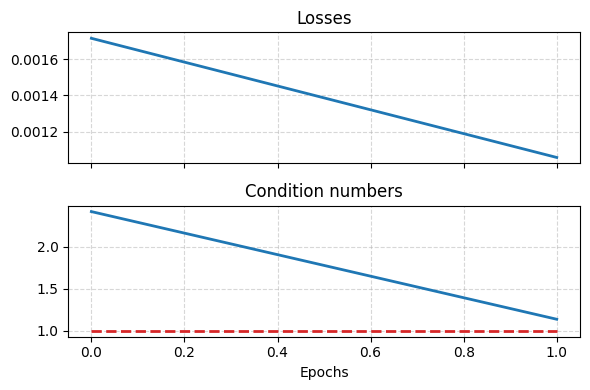

In [58]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, n_epochs+1)

ax = axes[0]
ax.plot(Ts, losses, 'tab:blue', linewidth=2)

ax.set_title('Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, conditions, 'tab:blue', linewidth=2)
ax.plot(Ts, np.ones(len(Ts)), 'tab:red', linewidth=2, linestyle='--')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('FIR_Tight.pdf', bbox_inches='tight')

In [142]:
# save w_init and w_tight_fir as input for the next notebook
w_fir_tight = baseline.psi.weight.detach().numpy()[:,0,:]
w_fir_tight = np.concatenate((w_fir_tight,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
np.save('w_init.npy', w_init)
np.save('w_fir_tight.npy', w_fir_tight)